In [54]:
import json
import pandas as pd
from collections import defaultdict
from scipy.stats import hypergeom
import seaborn as sns
import matplotlib.pyplot as plt

In [64]:
#path for summary of AlphaFolfd structures
reference_summary_path='../data/csv/summary_reference.csv'
isoform_summary_path='../data/csv/summary_isoform.csv'

#path for isoform and reference go
reference_go_path='../data/json/reference_go.json'
isoform_go_path='../data/json/isoform_go.json'

#path for the predicted probability for each go term
reference_go_prob_path='/home/yuxuans/alternative_splicing/metric/function/cofactor/reference/structure.tsv'
isoform_go_prob_path='/home/yuxuans/alternative_splicing/metric/function/cofactor/isoform/structure.tsv'

#path for as event
as_event_path='../data/json/as_event.json'

#path for go obo database file
go_obo_path='/home/yuxuans/alternative_splicing/metric/function/cofactor/go.obo'

<span style="font-size: 20px;">Plot for alternative splicing type affect gain/loss of function:</span>

In [4]:
def load_file_json(path):
    with open(path,'r') as load_f:
        file=json.load(load_f)
    return file

In [5]:
def read_data_from_file(file_path):
    with open(file_path, 'r') as file:
        data = file.readlines()
    return data

In [6]:
reference_go=load_file_json(reference_go_path)
isoform_go=load_file_json(isoform_go_path)
as_event=load_file_json(as_event_path)

In [7]:
isoform_summary=pd.read_csv(isoform_summary_path)
reference_summary=pd.read_csv(reference_summary_path)

In [8]:
#add the prediction quality, used for filter out low prediction quality structure
def add_quality(isoform_go,reference_go,isoform_summary,reference_summary):
    new_isoform_go={}
    new_reference_go={}
    for isoform in isoform_go.keys():
        if isoform in list(isoform_summary['isoform']):
            sub_isoform_df=isoform_summary[isoform_summary['isoform']==isoform].reset_index(drop=True)
            isoform_plddt=sub_isoform_df['plddt'][0]
            if float(isoform_plddt)>=70.0:
                new_isoform_go[isoform]=isoform_go[isoform]
    for reference in reference_go.keys():
        if reference in list(reference_summary['reference']):
            sub_reference_df=reference_summary[reference_summary['reference']==reference].reset_index(drop=True)
            reference_plddt=sub_reference_df['plddt'][0]
            if float(reference_plddt)>=70.0:
                new_reference_go[reference]=reference_go[reference]
    return new_isoform_go,new_reference_go
isoform_go_high_confident,reference_go_high_confident=add_quality(isoform_go,reference_go,isoform_summary,reference_summary)

In [9]:
#calculate the total number of go terms in the high and confident dataset, will be used in the hypergeometric test 
def count_go_dic(isoform_go_high_confidnet,reference_go_high_confident):
    count_isoform_go_dic = defaultdict(int)
    count_reference_go_dic = defaultdict(int)
    count_total_go_dic = defaultdict(int)
    for go_list in isoform_go_high_confident.values():
        for go in set(go_list):
            count_isoform_go_dic[go]+=1
            count_total_go_dic[go]+=1
            
    for go_list in reference_go_high_confident.values():
        for go in set(go_list):
            count_reference_go_dic[go]=+1
            count_total_go_dic[go]+=1
    return dict(count_isoform_go_dic),dict(count_reference_go_dic),dict(count_total_go_dic)

In [10]:
count_isoform_go_dic,count_reference_go_dic,count_total_go_dic=count_go_dic(isoform_go_high_confident,reference_go_high_confident)

In [11]:
#select the isoform with annotated alternative splicing types
def add_quality_type(isoform_go,reference_go,isoform_summary,reference_summary,as_event):
    new_isoform_go={}
    for isoform in isoform_go.keys():
        if isoform in list(isoform_summary['isoform']) and isoform.split('-')[0] in list(reference_summary['reference']):
            sub_isoform_df=isoform_summary[isoform_summary['isoform']==isoform].reset_index(drop=True)
            isoform_plddt=sub_isoform_df['plddt'][0]
            sub_reference_df=reference_summary[reference_summary['reference']==isoform.split('-')[0]].reset_index(drop=True)
            reference_plddt=sub_reference_df['plddt'][0]
            if float(isoform_plddt)>=70.0 and float(reference_plddt)>=70.0 and isoform in as_event.keys():
                if type(as_event[isoform])==list:
                    new_isoform_go[isoform]=isoform_go[isoform]
    return new_isoform_go

In [12]:
isoform_go_type=add_quality_type(isoform_go,reference_go,isoform_summary,reference_summary,as_event)

In [13]:
def unique_to_list(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    unique_elements = set1.difference(set2)
    unique_elements_list = list(unique_elements)
    return unique_elements_list

In [14]:
#get the gain/loss of GO terms for each isoform
def function_change_df(as_event,isoform_go,reference_go):
    index_list=[]
    for isoform in isoform_go.keys():
        for go in isoform_go[isoform]:
            if go not in index_list:
                index_list.append(go)
    for reference in reference_go.keys():
        for go in reference_go[reference]:
            if go not in index_list:
                index_list.append(go)
    column_names=['exon_skipping','alternative_donor_site','alternative_acceptor_site',
         'intron_retention','mutually_exclusive_exon','alternative_first_exon','alternative_last_exon',
         'mutually_exclusive_exon-alternative_first_exon','mutually_exclusive_exon-alternative_last_exon']
    gain_function_df=pd.DataFrame(index=index_list,columns=column_names)
    lose_function_df=pd.DataFrame(index=index_list,columns=column_names)
    gain_function_df = gain_function_df.fillna(0)
    lose_function_df = lose_function_df.fillna(0)
    for isoform in as_event:
        reference=isoform.split('-')[0]
        as_type=list(set(as_event[isoform]))
        if isoform in isoform_go.keys() and reference in reference_go.keys():
            gain_go_list=unique_to_list(isoform_go[isoform],reference_go[reference])
            lose_go_list=unique_to_list(reference_go[reference],isoform_go[isoform])
            if type(as_event[isoform])==list:
                for event in as_type:
                    if gain_go_list!=[]:
                        for go in gain_go_list:
                            gain_function_df[event][go]+=1
                    if lose_go_list!=[]:
                        for go in lose_go_list:
                            lose_function_df[event][go]+=1
    gain_function_df = gain_function_df[(gain_function_df != 0).any(axis=1)]
    lose_function_df = lose_function_df[(lose_function_df != 0).any(axis=1)]
    return gain_function_df,lose_function_df

In [15]:
gain_function,lose_function=function_change_df(as_event,isoform_go_high_confident,reference_go_high_confident)

In [16]:
#hypergeometric test
def hyper_test(function_change_df,isoform_go_quality_type,as_event):
    function_change_df_pval=function_change_df.copy()
    isoform_all=len(isoform_go_quality_type)
    for index in function_change_df.index:
        isoform_change_all=function_change_df.loc[index].sum()
        for event in function_change_df.columns:
            isoform_change_as=function_change_df[event][index]
            isoform_as=0
            for isoform in isoform_go_quality_type.keys():
                if event in as_event[isoform]:
                    isoform_as+=1
            pval = hypergeom.sf(isoform_change_as-1, isoform_all, isoform_as, isoform_change_all)
            function_change_df_pval[event][index]=pval
    return function_change_df_pval

In [17]:
gain_function_pval=hyper_test(gain_function,isoform_go_type,as_event)
lose_function_pval=hyper_test(lose_function,isoform_go_type,as_event)

/tmp/ipykernel_2155264/90651819.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  function_change_df_pval[event][index]=pval


In [18]:
#filter out go terms with too few gain/loss, and also filter some general GO terms
def filter_go(change_function_df,change_function_df_pval,count_total_go_dic,pval_threshould,count_threshold,background_threshold):
    go_list=[]
    sign_change_function_df_pval=change_function_df_pval[(change_function_df_pval < pval_threshould).any(axis=1)]
    for index in sign_change_function_df_pval.index:
        for column in sign_change_function_df_pval.columns:
            if sign_change_function_df_pval[column][index]<pval_threshould:
                selected_row = change_function_df.loc[index]
                go_count=selected_row[column]
                if go_count>count_threshold and count_total_go_dic[index]<background_threshold:
                    go_list.append(index)
    sign_change_function_df_pval=sign_change_function_df_pval.loc[go_list]
    return sign_change_function_df_pval
sign_gain_function=filter_go(gain_function,gain_function_pval,count_total_go_dic,0.05,5,10000)
sign_lose_function=filter_go(lose_function,lose_function_pval,count_total_go_dic,0.05,10,10000)

In [19]:
def extract_name_and_namespace(go_data, go_id,go_name=False):
    term = None
    in_term = False
    for line in go_data:
        line = line.strip()
        if line.startswith('[Term]'):
            in_term = True
            term = {'id': None, 'name': None, 'namespace': None}
        elif in_term and line.startswith('id: '):
            term['id'] = line.split(': ')[1]
        elif in_term and line.startswith('name: '):
            term['name'] = line.split(': ')[1]
        elif in_term and line.startswith('namespace: '):
            term['namespace'] = line.split(': ')[1]
        if go_id!=False:
            if term and line == '' and term['id'] == go_id:
                return term['name'], term['namespace']
        else:
            if term and line == '' and term['name'] == go_name:
                return term['id'], term['namespace']
    return None, None

In [20]:
def replace_name_df(change_function_df):
    new_column_names = ['Exon skipping', 'Alternative donor site', 'Alternative acceptor site',
                        'Intron retention','Mutually exclusive exon','Alternative first exon',
                        'Alternative last exon','Mutually Exclusive Exon'+'\n'+'Alternative First Exon',
                        'Mutually exclusive exon'+'\n'+'Alternative last exon']
    change_function_df.columns = new_column_names
    return change_function_df
sign_gain_function=replace_name_df(sign_gain_function)
sign_lose_function=replace_name_df(sign_lose_function)

In [21]:
go_obo=read_data_from_file(go_obo_path)

In [22]:
def remove_obsolete_df(go_data,change_function_df):
    new_index_list=[]
    for index in change_function_df.index:
        term_name=extract_name_and_namespace(go_data,index)[0]
        new_index=term_name
        new_index_list.append(new_index)
    change_function_df = change_function_df.reset_index(drop=True)
    change_function_df['index']=new_index_list
    change_function_df = change_function_df.set_index('index')
    mask = change_function_df.index.str.contains('obsolete')
    change_function_df_filtered = change_function_df[~mask]
    return change_function_df_filtered
sign_gain_function_name=remove_obsolete_df(go_obo,sign_gain_function)
sign_lose_function_name=remove_obsolete_df(go_obo,sign_lose_function)

In [23]:
def remove_dup_df(change_function_df):
    indices_to_remove = []    
    for i in change_function_df.index:
        for j in change_function_df.index:
            if i==j:
                continue
            if i in j:
                indices_to_remove.append(i)
    change_function_df = change_function_df.drop(indices_to_remove)
    #change_function_df = change_function_df.reset_index(drop=True)
    return change_function_df

In [24]:
sign_gain_function_name=remove_dup_df(sign_gain_function_name)

In [25]:
sign_lose_function_name=remove_dup_df(sign_lose_function_name)

In [26]:
def get_sub_go_list(go_data,change_function_df):
    sub_go_list=[]
    for index in change_function_df.index:
        term_namespace=extract_name_and_namespace(go_data,go_id=False,go_name=index)[1]
        if term_namespace=='biological_process':
            term_namespace='Biological process'
        elif term_namespace=='cellular_component':
            term_namespace='Cellular component'
        else:
            term_namespace='Molecular function'
        sub_go_list.append(term_namespace)
    return sub_go_list

In [52]:
def cluster_plot(go_data,change_function_df):
    #plt.figure(figsize=(1,5))
    category_colors = {'Biological process': 'blue','Cellular component': 'orange','Molecular function': 'green'}
    clustergrid=sns.clustermap(change_function_df,figsize=(12,21),dendrogram_ratio=(.15, .1),
                           tree_kws=dict(linewidths=4),col_cluster=False,cmap='rocket_r') 
    clustergrid.cax.set_visible(False)

    clustergrid.ax_heatmap.set_ylabel('')
    ytick_labels = clustergrid.ax_heatmap.get_yticklabels()
    clustered_function_df=clustergrid.data2d
    sub_go_list=get_sub_go_list(go_data,clustered_function_df)
    for label, category in zip(ytick_labels, sub_go_list):
        label.set_color(category_colors.get(category, 'gray'))
    clustergrid.ax_heatmap.set_xticklabels(clustergrid.ax_heatmap.get_xticklabels(), fontsize=18,fontweight='bold')
    clustergrid.ax_heatmap.set_yticklabels(clustergrid.ax_heatmap.get_yticklabels(), fontsize=28,fontweight='bold')
    #plt.savefig('lose_function_heatmap.png',dpi=600,bbox_inches='tight')
    plt.show()
    return True

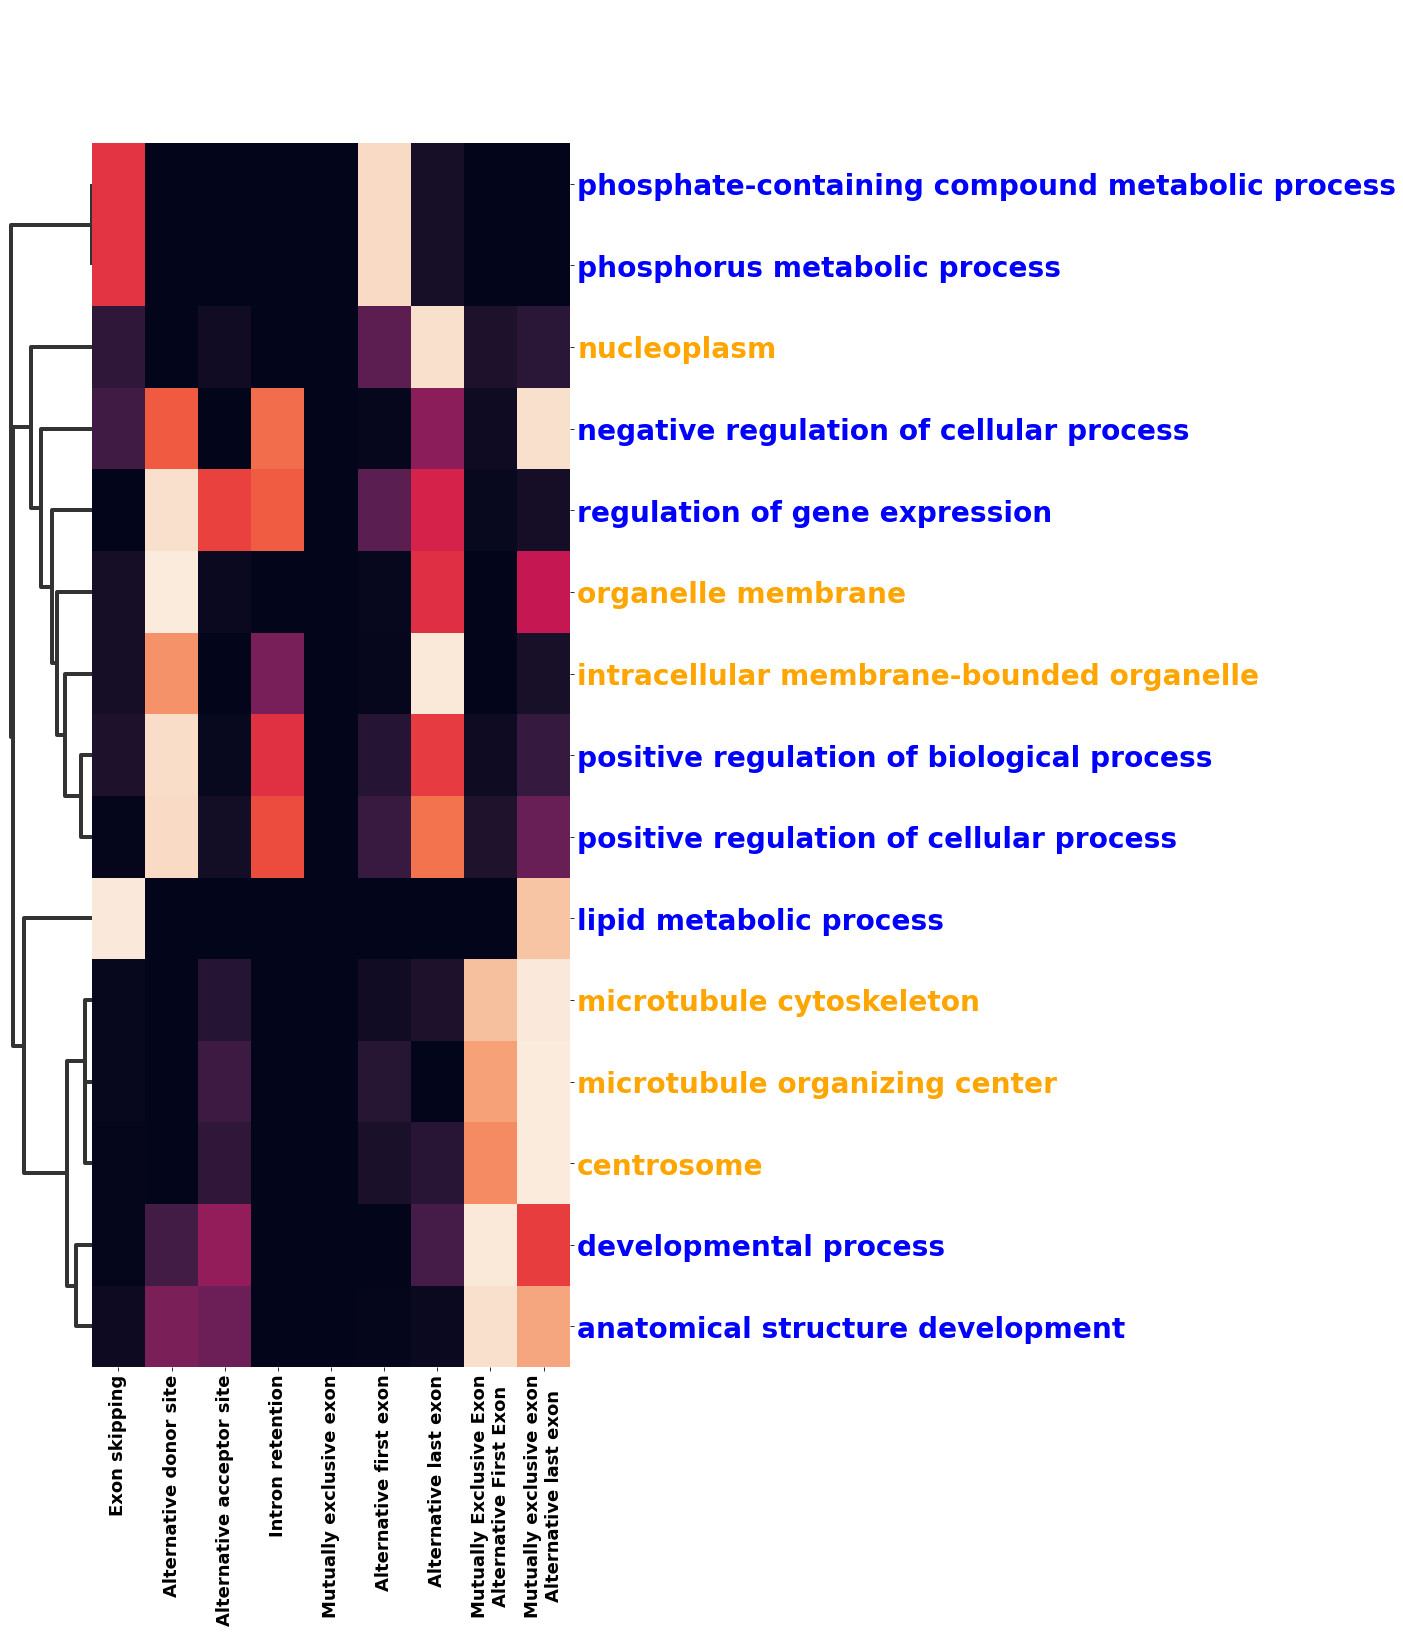

True

In [45]:
cluster_plot(go_obo,sign_gain_function_name)

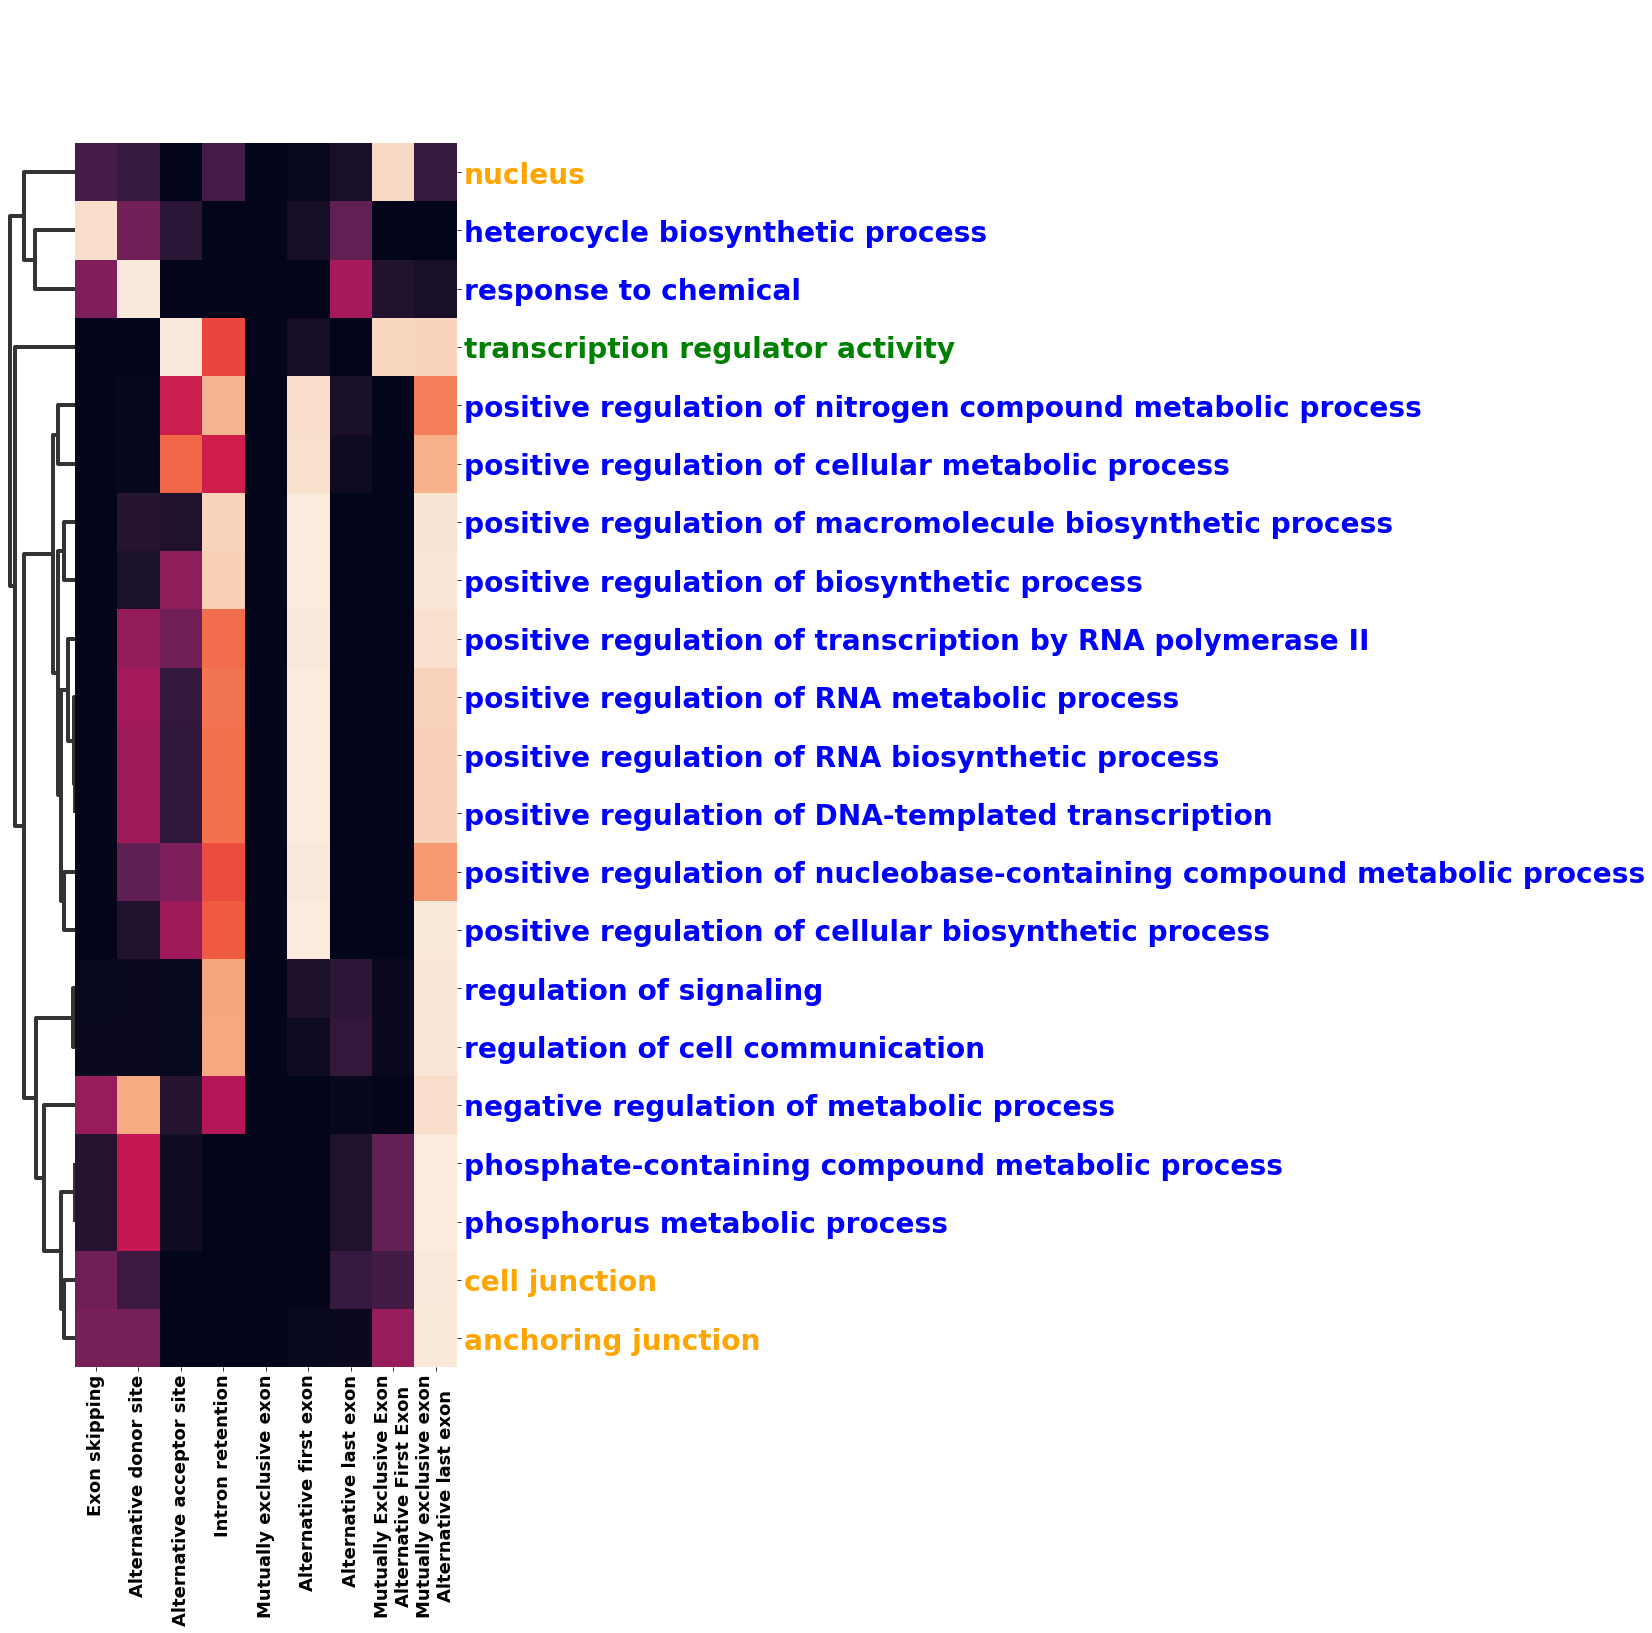

True

In [53]:
cluster_plot(go_obo,sign_lose_function_name)

<span style="font-size: 20px;">Plot for loss of function example: TPTE2 and TAFAZZIN</span>

In [65]:
#load predicted probability file
isoform_go_df = pd.read_csv(isoform_go_prob_path, sep='\t', header=None)
isoform_go_df.columns=['uniprot entry','go terms','probability']
reference_go_df = pd.read_csv(reference_go_prob_path, sep='\t', header=None)
reference_go_df.columns=['uniprot entry','go terms','probability']

In [66]:
#TPTE2
go_list=list(set(reference_go['Q6XPS3'])-set(isoform_go['Q6XPS3-4']))
go_list.remove('GO:0043226')
go_list.remove('GO:0043229')

In [67]:
def replace_go_df(go_data,plot_df):
    new_index_list=[]
    for index in range(len(plot_df['go terms'])):
        go=plot_df['go terms'][index]
        term_name=extract_name_and_namespace(go_data,go)[0]
        plot_df['go terms'][index]=term_name
    return plot_df

In [76]:
def plot_example_go_seperate(entry_go_df,entry,go_list,go_data,reference=True):
    plot_df=entry_go_df[(entry_go_df['uniprot entry']==entry) & 
                                     (entry_go_df['go terms'].isin(go_list))].reset_index(drop=True)
    plot_df=replace_go_df(go_data,plot_df)
    plot_df = plot_df.sort_values(by='go terms', ascending=True)
    if reference==True:
        plt.figure(figsize=(10,3))
        custom_palette = ["#F3BF70"]
        sns.barplot(x='probability',y='go terms',data=plot_df,palette=custom_palette)
        plt.xlim(0.4,0.7)
        plt.gca().axes.get_xaxis().set_visible(False)
        sns.despine(left=True, bottom=True)
        plt.yticks(fontsize=18,fontweight='bold')
        plt.ylabel('')
        plt.show()
    else:
        plt.figure(figsize=(10,3))
        custom_palette = ["#25D9F5"]
        sns.barplot(x='probability',y='go terms',data=plot_df,palette=custom_palette)
        plt.xlim(0.4,0.7)
        sns.despine(left=True)
        plt.yticks(fontsize=18,fontweight='bold')
        plt.xticks(fontsize=18,fontweight='bold')
        plt.xlabel('Probability',fontsize=20)
        plt.ylabel('')
        plt.show()
    return plot_df

/tmp/ipykernel_2155264/829424608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['go terms'][index]=term_name


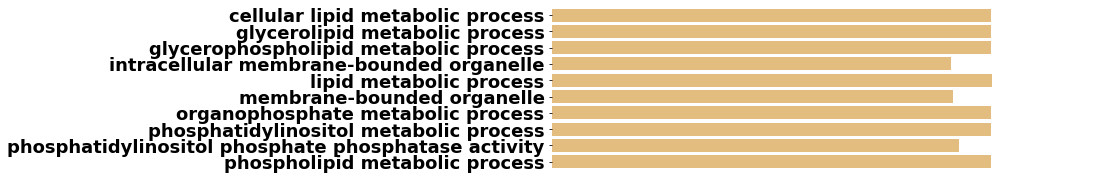

In [77]:
plot_reference_df=plot_example_go_seperate(reference_go_df,'Q6XPS3',go_list,go_obo)

/tmp/ipykernel_2155264/829424608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['go terms'][index]=term_name


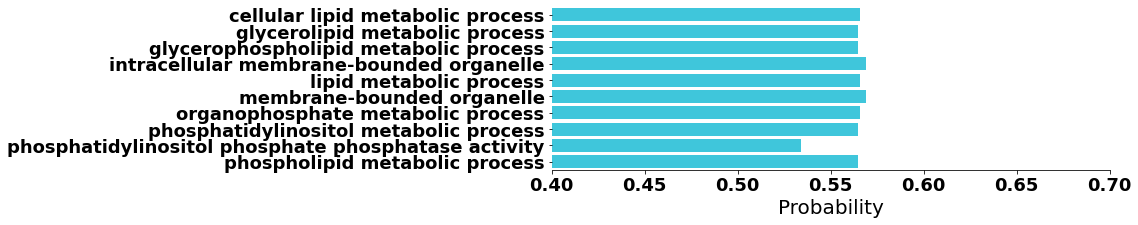

In [78]:
plot_isoform_df=plot_example_go_seperate(isoform_go_df,'Q6XPS3-4',go_list,go_obo,reference=False)

In [79]:
#TAFAZZIN
go_list=list(set(reference_go['Q16635'])-set(isoform_go['Q16635-7']))
go_list.remove('GO:0048468')
go_list.remove('GO:0048869')
go_list.remove('GO:0030154')

/tmp/ipykernel_2155264/829424608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['go terms'][index]=term_name


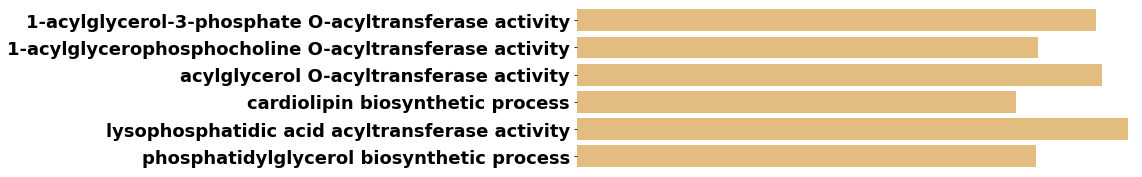

In [80]:
plot_reference_df=plot_example_go_seperate(reference_go_df,'Q16635',go_list,go_obo)

/tmp/ipykernel_2155264/829424608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['go terms'][index]=term_name


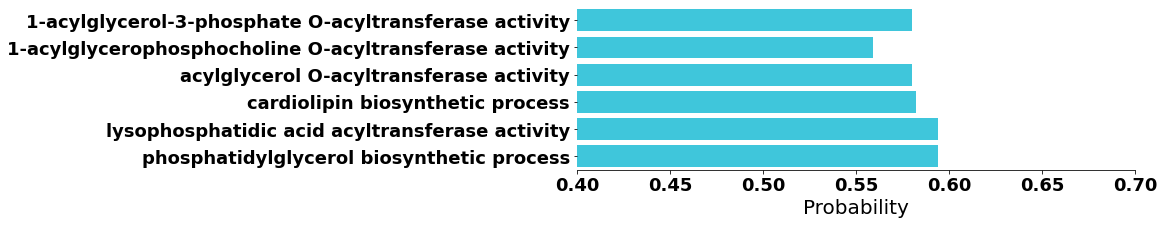

In [81]:
plot_isoform_df=plot_example_go_seperate(isoform_go_df,'Q16635-7',go_list,go_obo,reference=False)